In [34]:
# main imports

from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate

import xgboost as xgb

import joblib

from tqdm import tqdm

Performance measure is **Root-Mean-Squared-Error (RMSE) between the logarithm** of the predicted value and the logarithm of the observed sales price.  
Taking logs means that errors in predicting expensive houses and cheap houses will affect the result almost equally

In [2]:
from sklearn.metrics import mean_squared_log_error

In [3]:
df_orig = pd.read_csv('datasets/processed/train_with_cat_dtypes.csv', index_col=0)
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [4]:
y = df_orig['SalePrice'].to_numpy()

In [5]:
X = np.genfromtxt('datasets/processed/train_numpy.csv', delimiter=',')
X.shape

(1460, 242)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train sets size: ', X_train.shape, y_train.shape)
print('Test sets size: ', X_test.shape, y_test.shape)

Train sets size:  (1168, 242) (1168,)
Test sets size:  (292, 242) (292,)


In [13]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean: {:.4f}".format(scores.mean()))
    print("Standard deviation: {:.4f}".format(scores.std()))

In [8]:
tree_reg = RandomForestRegressor(n_estimators=100)

In [18]:
msle_scores = -cross_val_score(tree_reg, X_train, y_train, scoring='neg_mean_squared_log_error', cv=20)

In [19]:
display_scores(msle_scores)

Scores: [0.010413   0.01083772 0.0321938  0.0154611  0.01868446 0.01141718
 0.03638039 0.02950421 0.04792345 0.01663434 0.04662888 0.02125678
 0.01462603 0.02224293 0.01806678 0.01636184 0.01061323 0.02362926
 0.00881507 0.01369258]
Mean: 0.0213
Standard deviation: 0.0113


In [27]:
lin_reg = LinearRegression()

In [28]:
msle_scores_lin = -cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_log_error', cv=20)

d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

  warnings.war

In [29]:
display_scores(msle_scores_lin)

Scores: [0.0186931  0.01867981 0.03613792        nan 0.02071832 0.01549932
 0.09192751 0.03511453 0.06343416 0.04287464 0.03553469 0.03117754
 0.02805025 0.03150997 0.01474568 0.0315053  0.02848419 0.04272895
 0.05655863 0.01238099]
Mean: nan
Standard deviation: nan


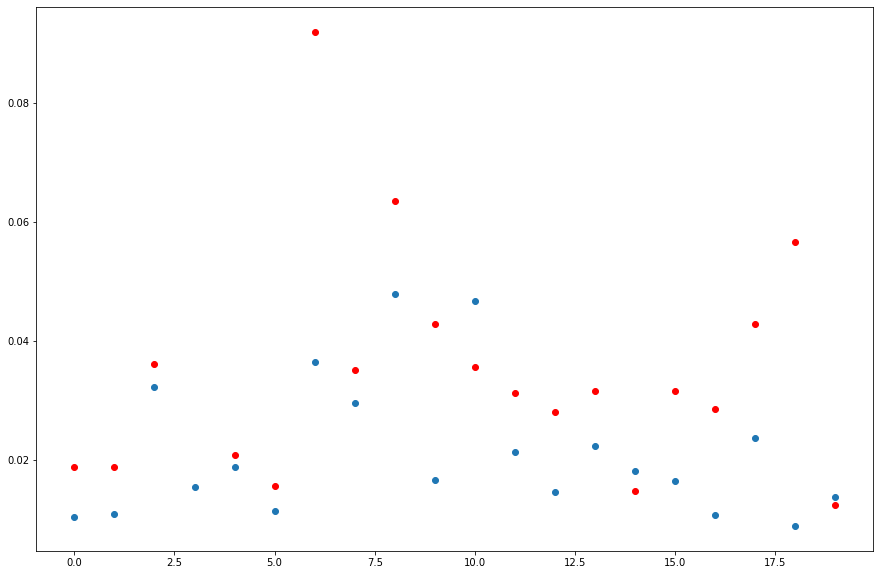

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.scatter(x=range(len(msle_scores)), y=msle_scores)
plt.scatter(x=range(len(msle_scores_lin)), y=msle_scores_lin, c='red')

In [8]:
tree_reg.fit(X_train, y_train)

RandomForestRegressor()

In [35]:
grid_params = [
    {'n_estimators': [10, 50, 100, 200], 'max_features': [2, 4, 6, 8],},
    {'bootstrap': [False], 'n_estimators': [10, 50, 100, 200], 'max_features': [2, 4, 6, 8]},
]
gscv_rforest = GridSearchCV(estimator=tree_reg, param_grid=grid_params, cv=5, scoring='neg_mean_squared_log_error', return_train_score=True)

In [36]:
gscv_rforest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [10, 50, 100, 200]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [10, 50, 100, 200]}],
             return_train_score=True, scoring='neg_mean_squared_log_error')

In [37]:
gscv_rforest.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 200}

In [38]:
gscv_res = gscv_rforest.cv_results_

In [40]:
gscv_res.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'param_bootstrap', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [39]:
for mean_score, params in zip(gscv_res["mean_test_score"], gscv_res["params"]):
    print(-mean_score, params)

0.03647686859973566 {'max_features': 2, 'n_estimators': 10}
0.029254504856119017 {'max_features': 2, 'n_estimators': 50}
0.02976401726139714 {'max_features': 2, 'n_estimators': 100}
0.028734784226433708 {'max_features': 2, 'n_estimators': 200}
0.03302302353676654 {'max_features': 4, 'n_estimators': 10}
0.027548639397705955 {'max_features': 4, 'n_estimators': 50}
0.026643955345885973 {'max_features': 4, 'n_estimators': 100}
0.02624447728144292 {'max_features': 4, 'n_estimators': 200}
0.030348341338949363 {'max_features': 6, 'n_estimators': 10}
0.025300570824234835 {'max_features': 6, 'n_estimators': 50}
0.025055393661315612 {'max_features': 6, 'n_estimators': 100}
0.024865025852953557 {'max_features': 6, 'n_estimators': 200}
0.028214580106186125 {'max_features': 8, 'n_estimators': 10}
0.023572442522464293 {'max_features': 8, 'n_estimators': 50}
0.023617357802573784 {'max_features': 8, 'n_estimators': 100}
0.023620162326752833 {'max_features': 8, 'n_estimators': 200}
0.034644625520905914

In [41]:
rforest_reg = gscv_rforest.best_estimator_

In [42]:
rforest_reg.score(X_test, y_test)

0.8528427599417183

In [43]:
mean_squared_log_error(y_test, rforest_reg.predict(X_test))


0.027649950113018046

In [45]:
rforest_reg

RandomForestRegressor(bootstrap=False, max_features=8, n_estimators=200)

In [69]:
grid_params = [
    {'bootstrap': [False], 'n_estimators': [x for x in range(100, 1001, 100)]} # , 'max_features': [2, 4, 6, 8]
]

In [70]:
gscv_rforest = GridSearchCV(estimator=rforest_reg, param_grid=grid_params, cv=10, scoring='neg_mean_squared_log_error', return_train_score=True)

In [71]:
gscv_rforest.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestRegressor(bootstrap=False, max_features=8,
                                             n_estimators=200),
             param_grid=[{'bootstrap': [False],
                          'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                           800, 900, 1000]}],
             return_train_score=True, scoring='neg_mean_squared_log_error')

In [72]:
gscv_rforest_res = gscv_rforest.cv_results_

In [49]:
gscv_rforest_res.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [73]:
param_n_estimators = [x['n_estimators'] for x in gscv_rforest_res['params']]
len(param_n_estimators)

10

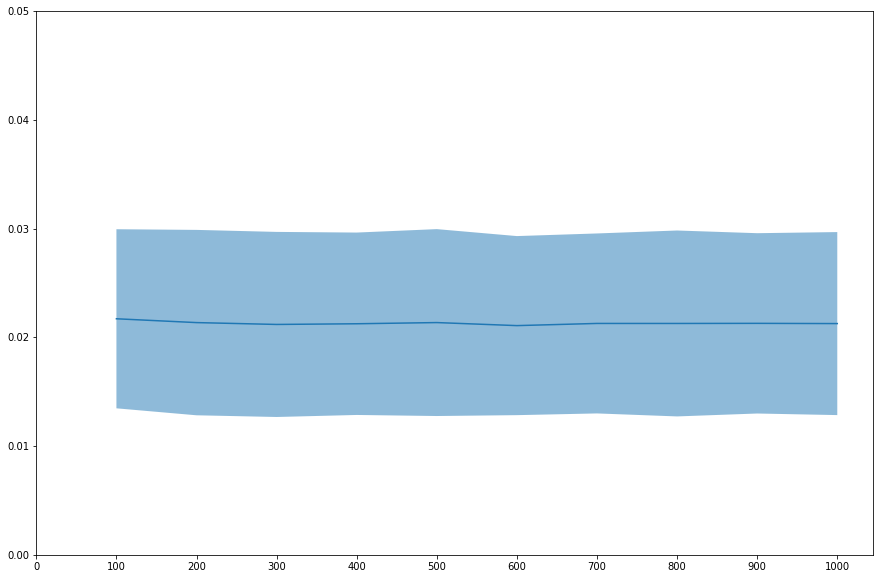

In [76]:
upper_bound = -gscv_rforest_res['mean_test_score'] + gscv_rforest_res['std_test_score']
lower_bound = -gscv_rforest_res['mean_test_score'] - gscv_rforest_res['std_test_score']
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(param_n_estimators, -gscv_rforest_res['mean_test_score'])
plt.fill_between(param_n_estimators, upper_bound, lower_bound, alpha=0.5)
ax.set_ybound(lower=0.0, upper=0.05)
plt.xticks(range(0, 1001, 100));

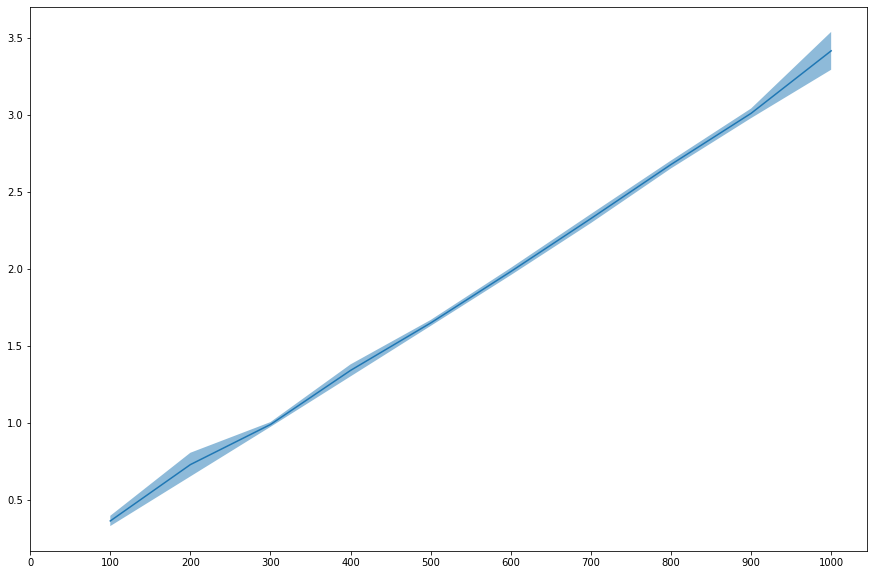

In [75]:
fittime_upper_bound = gscv_rforest_res['mean_fit_time'] + gscv_rforest_res['std_fit_time']
fittime_lower_bound = gscv_rforest_res['mean_fit_time'] - gscv_rforest_res['std_fit_time']
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(param_n_estimators, gscv_rforest_res['mean_fit_time'])
plt.fill_between(param_n_estimators, fittime_upper_bound, fittime_lower_bound, alpha=0.5)
plt.xticks(range(0, 1001, 100));
#ax.set_ybound(lower=0.0, upper=0.05)

In [77]:
gscv_rforest.best_estimator_.n_estimators

600

In [78]:
grid_params = [
    {'bootstrap': [False], 'n_estimators': [600], 'max_features': [x for x in range(2, 21, 2)]}
]
gscv_rforest = GridSearchCV(estimator=rforest_reg, param_grid=grid_params, cv=10, scoring='neg_mean_squared_log_error', return_train_score=True)

In [79]:
gscv_rforest.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestRegressor(bootstrap=False, max_features=8,
                                             n_estimators=200),
             param_grid=[{'bootstrap': [False],
                          'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                          'n_estimators': [600]}],
             return_train_score=True, scoring='neg_mean_squared_log_error')

In [81]:
gscv_rforest_res = gscv_rforest.cv_results_

In [82]:
x_params = [x['max_features'] for x in gscv_rforest_res['params']]
len(x_params)

10

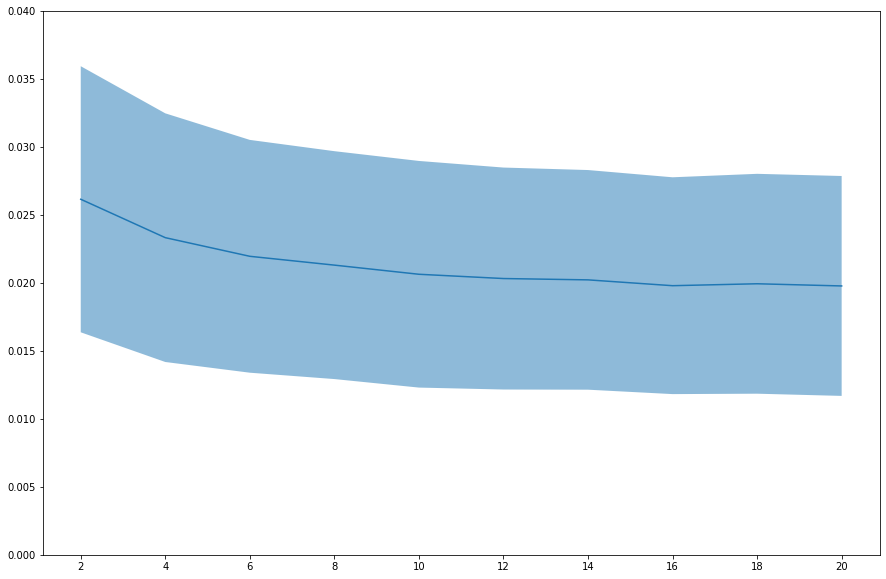

In [86]:
upper_bound = -gscv_rforest_res['mean_test_score'] + gscv_rforest_res['std_test_score']
lower_bound = -gscv_rforest_res['mean_test_score'] - gscv_rforest_res['std_test_score']
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(x_params, -gscv_rforest_res['mean_test_score'])
plt.fill_between(x_params, upper_bound, lower_bound, alpha=0.5)
ax.set_ybound(lower=0.0, upper=0.04)
plt.xticks(x_params);

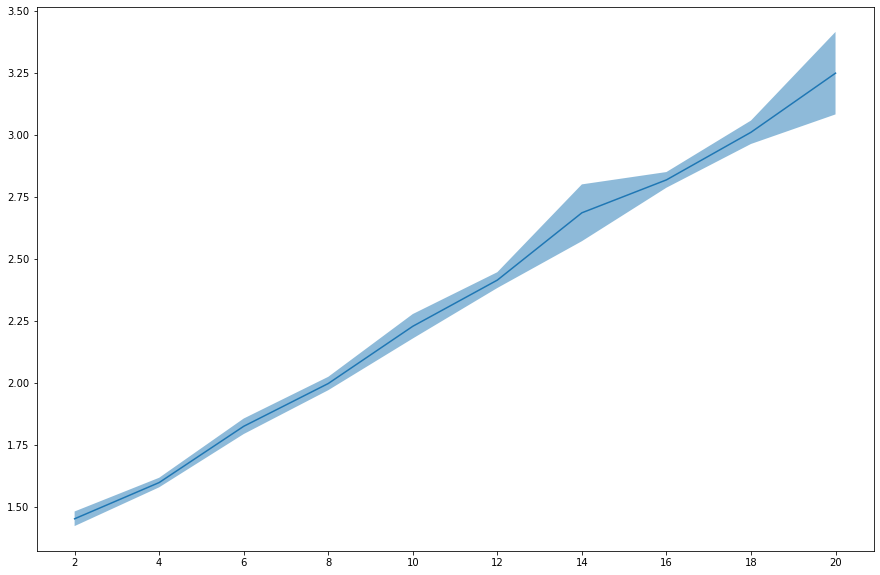

In [84]:
fittime_upper_bound = gscv_rforest_res['mean_fit_time'] + gscv_rforest_res['std_fit_time']
fittime_lower_bound = gscv_rforest_res['mean_fit_time'] - gscv_rforest_res['std_fit_time']
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(x_params, gscv_rforest_res['mean_fit_time'])
plt.fill_between(x_params, fittime_upper_bound, fittime_lower_bound, alpha=0.5)
plt.xticks(x_params);
#ax.set_ybound(lower=0.0, upper=0.05)

In [90]:
work_model = gscv_rforest.best_estimator_

## Make 1st prediction submit for Kaggle

In [87]:
# loading processed data from data_clean_prepare.ipynb results
final_X_test = np.genfromtxt('datasets/processed/test_numpy.csv', delimiter=',')
final_X_test.shape

(1459, 242)

In [92]:
df_test = pd.read_csv('datasets/test.csv', index_col=0)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearB

In [91]:
predictions = work_model.predict(final_X_test)

In [95]:
df_predictions = pd.Series(predictions, index=df_test.index, name='SalePrice')
df_predictions.info()

<class 'pandas.core.series.Series'>
Int64Index: 1459 entries, 1461 to 2919
Series name: SalePrice
Non-Null Count  Dtype  
--------------  -----  
1459 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


In [96]:
df_predictions.to_csv('datasets/test_predictions_v1.csv')